# Loan Data from Prosper


## Preliminary Wrangling

### Data set description
This data set contains 113,937 loans with 81 variables on each loan, including loan amount, borrower rate (or interest rate), current loan status, borrower income, and many others.

### What's expected
In this notebook we will try to explore data to find answers to these questions:
- What factors affect a loan’s outcome status?

- What affects the borrower’s APR or interest rate?

- Are there differences between loans depending on how large the original loan amount was?

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import os
import glob
from IPython.display import display, HTML


%matplotlib inline

### Gathering and Assessing Data

In [28]:
# only ran once to append all monthly trip data together

df = pd.read_csv('Data/prosperLoanData.csv')
print(df.shape)
display(df.head())

(113937, 81)


,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
0,1021339766868145413AB3B,193129,2007-08-26 19:09:29.263000000,C,36,Completed,2009-08-14 00:00:00,0.16516,0.1580,0.1380,...,-133.18,0.0,0.0,0.0,0.0,1.0,0,0,0.0,258
1,10273602499503308B223C1,1209647,2014-02-27 08:28:07.900000000,NaN,36,Current,NaN,0.12016,0.0920,0.0820,...,0.00,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
2,0EE9337825851032864889A,81716,2007-01-05 15:00:47.090000000,HR,36,Completed,2009-12-17 00:00:00,0.28269,0.2750,0.2400,...,-24.20,0.0,0.0,0.0,0.0,1.0,0,0,0.0,41
3,0EF5356002482715299901A,658116,2012-10-22 11:02:35.010000000,NaN,36,Current,NaN,0.12528,0.0974,0.0874,...,-108.01,0.0,0.0,0.0,0.0,1.0,0,0,0.0,158
4,0F023589499656230C5E3E2,909464,2013-09-14 18:38:39.097000000,NaN,36,Current,NaN,0.24614,0.2085,0.1985,...,-60.27,0.0,0.0,0.0,0.0,1.0,0,0,0.0,20


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 81 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   ListingKey                           113937 non-null  object 
 1   ListingNumber                        113937 non-null  int64  
 2   ListingCreationDate                  113937 non-null  object 
 3   CreditGrade                          28953 non-null   object 
 4   Term                                 113937 non-null  int64  
 5   LoanStatus                           113937 non-null  object 
 6   ClosedDate                           55089 non-null   object 
 7   BorrowerAPR                          113912 non-null  float64
 8   BorrowerRate                         113937 non-null  float64
 9   LenderYield                          113937 non-null  float64
 10  EstimatedEffectiveYield              84853 non-null   float64
 11  EstimatedLoss

We have like 80 features so we will to choose subset of them to help with our problem

In [30]:

# Subset the dataframe by selecting features of interest
cols = ['ListingNumber','ListingCreationDate','LoanOriginalAmount','LoanStatus','ListingCategory (numeric)','BorrowerState','BorrowerAPR','BorrowerRate','StatedMonthlyIncome', 'ProsperRating (Alpha)', 
        'Occupation','Term','EmploymentStatus','TotalInquiries','DebtToIncomeRatio','MonthlyLoanPayment','TotalTrades','Investors']
df_loan = df[cols]
display(df_loan.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ListingNumber              113937 non-null  int64  
 1   ListingCreationDate        113937 non-null  object 
 2   LoanOriginalAmount         113937 non-null  int64  
 3   LoanStatus                 113937 non-null  object 
 4   ListingCategory (numeric)  113937 non-null  int64  
 5   BorrowerState              108422 non-null  object 
 6   BorrowerAPR                113912 non-null  float64
 7   BorrowerRate               113937 non-null  float64
 8   StatedMonthlyIncome        113937 non-null  float64
 9   ProsperRating (Alpha)      84853 non-null   object 
 10  Occupation                 110349 non-null  object 
 11  Term                       113937 non-null  int64  
 12  EmploymentStatus           111682 non-null  object 
 13  TotalInquiries             11

None

Then will display random rows to get better understanding of data.

In [31]:
display(df_loan.sample(10))

,ListingNumber,ListingCreationDate,LoanOriginalAmount,LoanStatus,ListingCategory (numeric),BorrowerState,BorrowerAPR,BorrowerRate,StatedMonthlyIncome,ProsperRating (Alpha),Occupation,Term,EmploymentStatus,TotalInquiries,DebtToIncomeRatio,MonthlyLoanPayment,TotalTrades,Investors
12640,23615,2006-07-08 10:19:31.500000000,1400,Chargedoff,0,FL,0.19052,0.1775,5166.666667,NaN,NaN,36,NaN,6.0,0.13,50.44,NaN,1
86965,478536,2010-10-08 12:50:38.357000000,12000,Completed,7,MA,0.13271,0.1115,3916.666667,A,Professional,36,Employed,5.0,0.14,393.72,28.0,287
71593,893545,2013-09-12 18:31:55.060000000,10000,Current,1,MN,0.28078,0.2549,2916.666667,E,Realtor,60,Self-employed,0.0,0.37,296.39,16.0,95
93870,558009,2012-02-13 06:54:05.460000000,15000,Completed,2,FL,0.27246,0.2468,11000.000000,C,Architect,60,Employed,7.0,0.18,437.46,18.0,221
44255,297534,2008-03-22 18:56:27.220000000,3000,Chargedoff,7,OH,0.21679,0.1945,5000.000000,NaN,Other,36,Full-time,18.0,0.28,110.65,35.0,52
35212,1098912,2013-12-19 18:27:18.907000000,2000,Current,1,CA,0.16324,0.1274,6074.250000,B,Skilled Labor,36,Employed,12.0,0.26,67.14,26.0,1
101714,107558,2007-03-06 16:06:21.343000000,3000,Completed,0,NaN,0.20735,0.2000,945.000000,NaN,Student - College Freshman,36,Part-time,5.0,0.14,109.85,5.0,39
83094,570763,2012-03-21 15:29:28.730000000,3500,Current,2,NH,0.35797,0.3177,16666.666667,HR,Executive,36,Employed,9.0,0.14,151.99,24.0,15
77313,578779,2012-04-14 15:36:32.973000000,13500,Current,1,FL,0.22742,0.1902,11666.666667,C,Investor,36,Self-employed,3.0,NaN,494.99,14.0,187
9912,706296,2013-01-29 09:52:20.243000000,25000,Current,14,TX,0.19236,0.1559,15250.000000,B,Professional,36,Employed,1.0,0.20,873.87,36.0,392


# Cleaning data

In [32]:
df_loan.duplicated().sum()

871

We have 871 duplicates so we will drop them

In [33]:
df_loan = df_loan.drop_duplicates()
df_loan.duplicated().sum()

0

selecting rows only where ProsperRating is not null as this is one of the most important features of the dataset ,as filling in missing values is not possible.

In [34]:
df_loan = df_loan[df_loan['ProsperRating (Alpha)'].notnull()]

filling missing values for the Occupation as unknown

In [35]:
df_loan.Occupation = df_loan.Occupation.fillna('Unknown')

filling in missing values of DebtToIncomeRatio as mean of the column

In [36]:
df_loan.DebtToIncomeRatio = df_loan.DebtToIncomeRatio.fillna(df_loan.DebtToIncomeRatio.mean())

converting datatypes of the required columns

In [37]:
df_loan.TotalInquiries = df_loan.TotalInquiries.astype(int)
df_loan.TotalTrades = df_loan.TotalTrades.astype(int)

Splitting ListingCreationDate column into year,month,day,time

In [38]:
df_loan['year']=df_loan['ListingCreationDate'].apply(lambda x: x.split("-")[0]).astype(str)
df_loan['month'] = df_loan['ListingCreationDate'].apply(lambda x: x.split("-")[1]).astype(str)
df_loan.month.unique()

array(['02', '10', '09', '12', '04', '05', '07', '08', '11', '01', '06',
       '03'], dtype=object)

In [39]:
df_loan.month.replace(['01','02','03','04','05','06','07','08','09','10','11','12'],['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec'],inplace = True)
df_loan.month.unique()

array(['Feb', 'Oct', 'Sept', 'Dec', 'Apr', 'May', 'Jul', 'Aug', 'Nov',
       'Jan', 'Jun', 'Mar'], dtype=object)

In [40]:
df_loan['ListingCreationDate'] = df_loan['ListingCreationDate'].apply(lambda x: x.split("-")[2]).astype(str)
df_loan['day'] = df_loan['ListingCreationDate'].apply(lambda x: x.split(" ")[0]).astype(str)
df_loan['time'] = df_loan['ListingCreationDate'].apply(lambda x: x.split(" ")[1]).astype(str)

drop the original ListingCreationDate column

In [41]:
df_loan.drop(columns = ['ListingCreationDate'],inplace = True)


### Exploring data

Let's see the info of data after cleaning it.

In [42]:
df_loan.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 83982 entries, 1 to 113936
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ListingNumber              83982 non-null  int64  
 1   LoanOriginalAmount         83982 non-null  int64  
 2   LoanStatus                 83982 non-null  object 
 3   ListingCategory (numeric)  83982 non-null  int64  
 4   BorrowerState              83982 non-null  object 
 5   BorrowerAPR                83982 non-null  float64
 6   BorrowerRate               83982 non-null  float64
 7   StatedMonthlyIncome        83982 non-null  float64
 8   ProsperRating (Alpha)      83982 non-null  object 
 9   Occupation                 83982 non-null  object 
 10  Term                       83982 non-null  int64  
 11  EmploymentStatus           83982 non-null  object 
 12  TotalInquiries             83982 non-null  int32  
 13  DebtToIncomeRatio          83982 non-null  fl

Then let's see the statistics of our data.

In [43]:
df_loan.describe()

,ListingNumber,LoanOriginalAmount,ListingCategory (numeric),BorrowerAPR,BorrowerRate,StatedMonthlyIncome,Term,TotalInquiries,DebtToIncomeRatio,MonthlyLoanPayment,TotalTrades,Investors
count,8.398200e+04,83982.000000,83982.000000,83982.000000,83982.00000,8.398200e+04,83982.000000,83982.000000,83982.000000,83982.00000,83982.000000,83982.000000
mean,7.712395e+05,9061.224381,3.321771,0.226945,0.19630,5.930614e+03,42.462813,4.285514,0.258692,291.40139,23.925115,68.677788
std,2.359100e+05,6279.649648,4.368851,0.080047,0.07475,8.268432e+03,11.639032,3.828780,0.305687,186.47539,11.610432,95.318077
min,4.162750e+05,1000.000000,0.000000,0.045830,0.04000,0.000000e+00,12.000000,0.000000,0.000000,0.00000,1.000000,1.000000
25%,5.570608e+05,4000.000000,1.000000,0.163610,0.13590,3.426938e+03,36.000000,2.000000,0.160000,157.11250,15.000000,1.000000
50%,7.341785e+05,7500.000000,1.000000,0.219450,0.18750,5.000000e+03,36.000000,3.000000,0.240000,251.28000,23.000000,32.000000
75%,9.756778e+05,13500.000000,3.000000,0.292540,0.25740,7.083333e+03,60.000000,6.000000,0.310000,387.62000,31.000000,98.000000
max,1.255725e+06,35000.000000,20.000000,0.423950,0.36000,1.750003e+06,60.000000,78.000000,10.010000,2251.51000,122.000000,1189.000000


### What is the structure of your dataset?
After cleaning the data, we now have 83982 loans with 21 features.

### What is/are the main feature(s) of interest in your dataset?
I'm most interested in figuring out what features are best for predicting the borrower's Annual Percentage Rate (APR) for the loan and how employment status and debtToIncome ratio associates with various metrics in the dataset.epend on if a user is a subscriber or customer?

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

- Total loan amount will have a negative effect on the APR of the loan: the larger the total loan amount, the lower the APR.
- Prosper rating, employment status will also have effects on the APR.
- Employment status and occupation will affect out ProsperRating and loan Amount.

## Univariate Exploration


In [44]:
rate_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec']
ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                    categories = rate_order)
df_loan['month'] = df_loan['month'].astype(ordered_var)
df_loan.groupby('month')['ListingNumber'].count()

month
Jan     9036
Feb     7887
Mar     5376
Apr     4906
May     5469
Jun     5805
Jul     6630
Aug     6401
Sept    7480
Oct     8586
Nov     8122
Dec     8284
Name: ListingNumber, dtype: int64

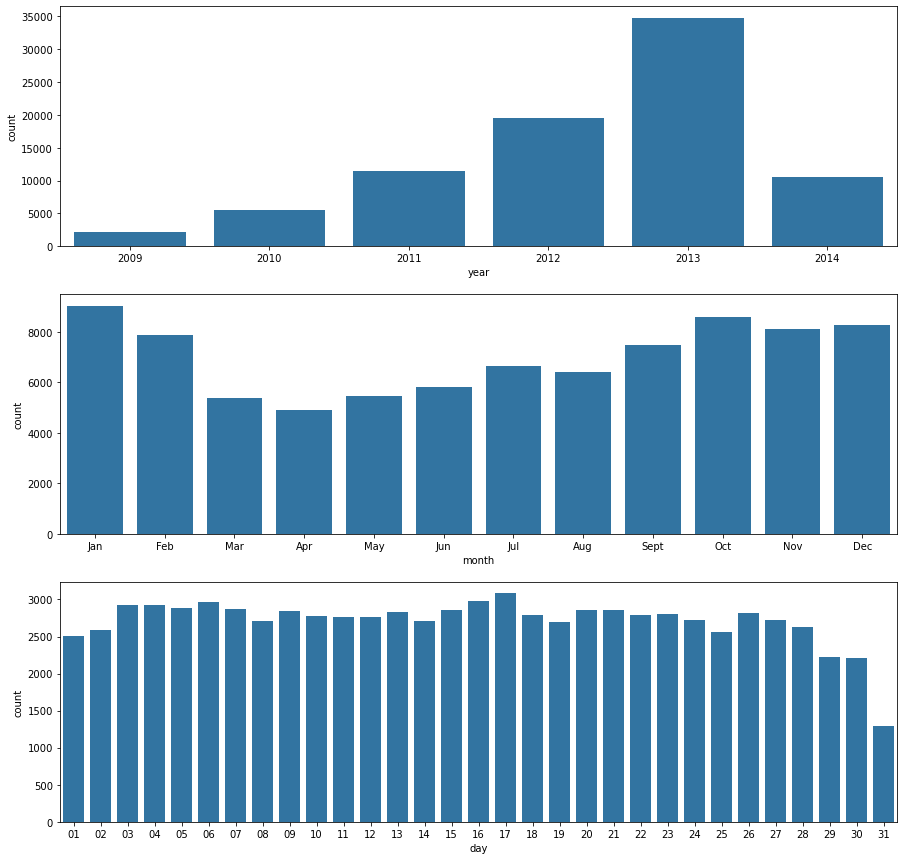

In [45]:
fig, ax = plt.subplots(nrows=3, figsize = [15,15])
default_color = sb.color_palette()[0]
sb.countplot(data = df_loan, x = 'year', color = default_color, ax = ax[0])
sb.countplot(data = df_loan, x = 'month', color = default_color, ax = ax[1])
sb.countplot(data = df_loan, x = 'day', color = default_color, ax = ax[2])

Let's start by looking at the distribution of the main variable of interest: borrower APR.

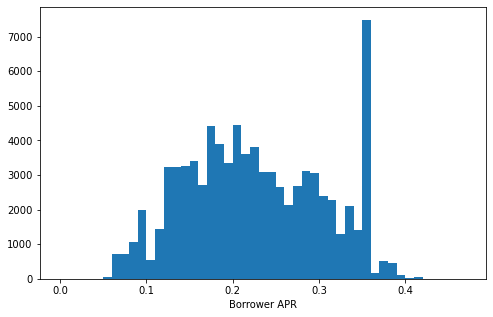

In [46]:
bins = np.arange(0, df_loan.BorrowerAPR.max()+0.05, 0.01)
plt.figure(figsize=[8, 5])
plt.hist(data = df_loan, x = 'BorrowerAPR', bins = bins);
plt.xlabel('Borrower APR');

The distribution of APR looks multimodal. A small peak centered at 0.1, a large peak centered at 0.2. There is also a small peak centered 0.3. Additionally, there is a very shape peak between 0.35 and 0.36. Only very few loans have APR greater than 0.43.

Now let's see the DebtToIncomeRatio deistrubition

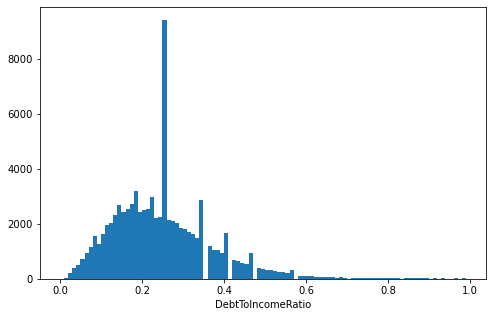

In [47]:
bins = np.arange(0,1, 0.01)
plt.figure(figsize=[8, 5])
plt.hist(data = df_loan, x = 'DebtToIncomeRatio', bins = bins);
plt.xlabel('DebtToIncomeRatio');

This graph indicates that there's a 1:4 ratio of debt to income as it has an unimodal peak around 0.2 and a very high peak around 0.25.

Next up, look at the distribution of the first predictor variable of interest: LoanOriginalAmount

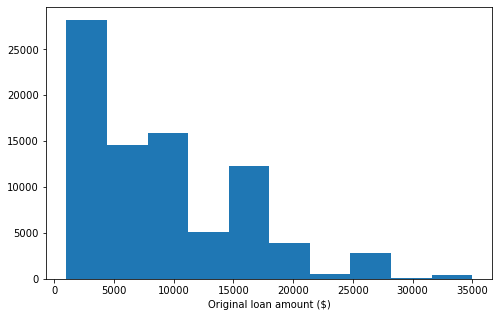

In [49]:
plt.figure(figsize=[8, 5])
plt.hist(df_loan['LoanOriginalAmount']);
plt.xlabel('Original loan amount ($)');

Most of the loans are multiple of 5k.

stated monthly income distrubition

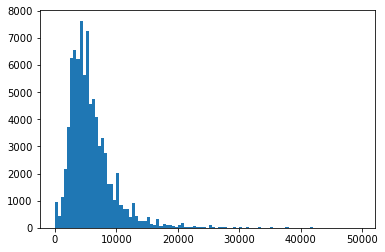

In [50]:
bins_smi = np.arange(0, 50000, 500)
plt.hist(data = df_loan, x = 'StatedMonthlyIncome', bins=bins_smi);

It's s severely right screwed, with stated monthly income less than 30k. and peak around 6K.
here we can see there are some outliers around 100K and 50K which should be removed.

In [51]:
df_loan = df_loan[df_loan.StatedMonthlyIncome<30000]


Then we will check distrubitions  for Occupation, Prosper rating and employment status

In [52]:
rate_order = ['HR','E','D','C','B','A','AA']
ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                    categories = rate_order)
df_loan['ProsperRating (Alpha)'] = df_loan['ProsperRating (Alpha)'].astype(ordered_var)

emp_order = ['Employed','Self-employed','Full-time','Part-time','Retired','Other','Not employed', 'Not available']
ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                    categories = emp_order)
df_loan['EmploymentStatus'] = df_loan['EmploymentStatus'].astype(ordered_var)

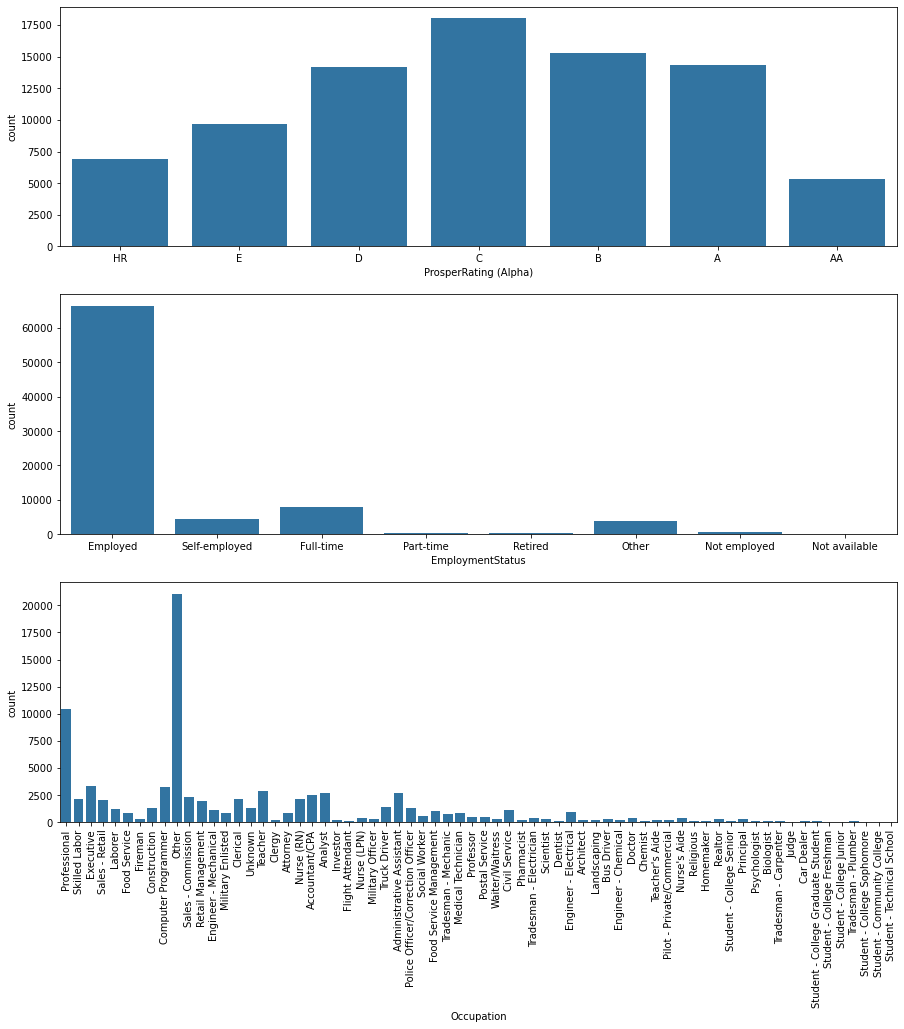

In [53]:
fig, ax = plt.subplots(nrows=3, figsize = [15,15])
default_color = sb.color_palette()[0]
sb.countplot(data = df_loan, x = 'ProsperRating (Alpha)', color = default_color, ax = ax[0])
sb.countplot(data = df_loan, x = 'EmploymentStatus', color = default_color, ax = ax[1]);
sb.countplot(data = df_loan, x = 'Occupation', color = default_color, ax = ax[2]);
plt.xticks(rotation=90);

The least of the borrowers are students. The ratings of most of the borrowers are among D to A. Most of borrowers are employed and full-time.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

The distribution of borrowers APR looks multimodal. Most of the values are at the range of 0.05 and 0.4. There are no unusual points and no need to perform any transformations.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

The distributions of stated monthly income is highly right screwed. DebtToIncomeRatio is also right skewed. There is no need to perform any transformations.



In [54]:
# save the clean data to a .csv file

df_loan.to_csv('dfLoan_clean.csv', index=False)

## Bivariate Exploration

I like to start by checking correlation between variables.

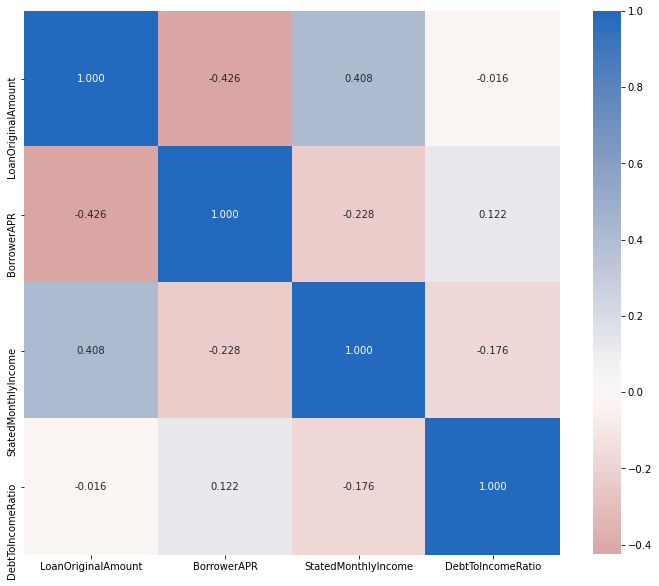

In [55]:
num_vars = ['LoanOriginalAmount', 'BorrowerAPR', 'StatedMonthlyIncome','DebtToIncomeRatio']
cat_vars = ['Term','ProsperRating (Alpha)', 'EmploymentStatus','Occupation']
plt.figure(figsize = [12, 10])
sb.heatmap(df_loan[num_vars].corr(), annot = True, fmt = '.3f',
           cmap = 'vlag_r', center = 0);

we can see the high correlation berween the monthly income and loan amount, and a very low correlation between borower apr and loan amount

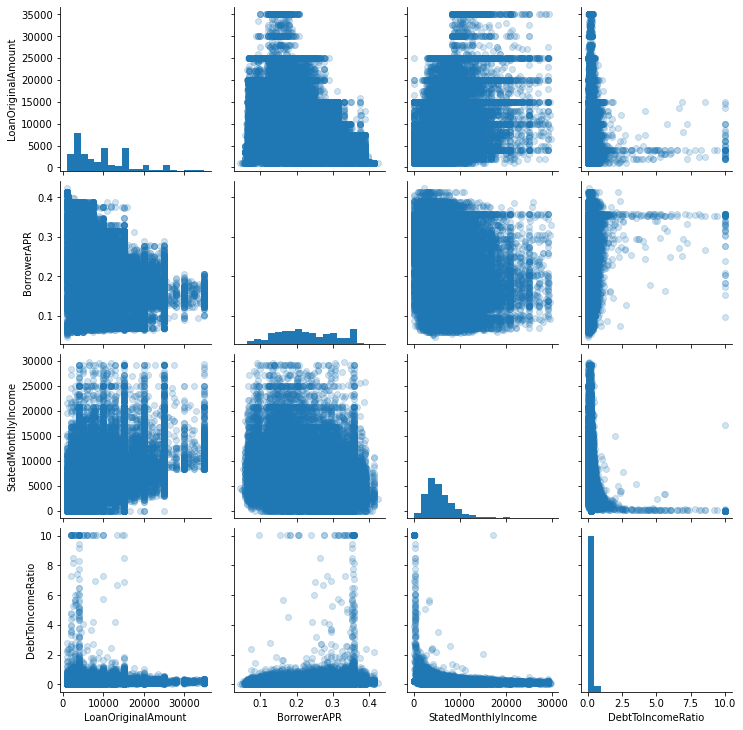

In [57]:
g = sb.PairGrid(data = df_loan, vars = num_vars)
g = g.map_diag(plt.hist, bins=20)
g.map_offdiag(plt.scatter, alpha=0.2);

The pair plot justifies the correlation, that is the more the loan amount, the lower the APR and orrowers with more monthly income could loan more money.

We will justify more with categorical variables.

<Figure size 1440x1440 with 0 Axes>

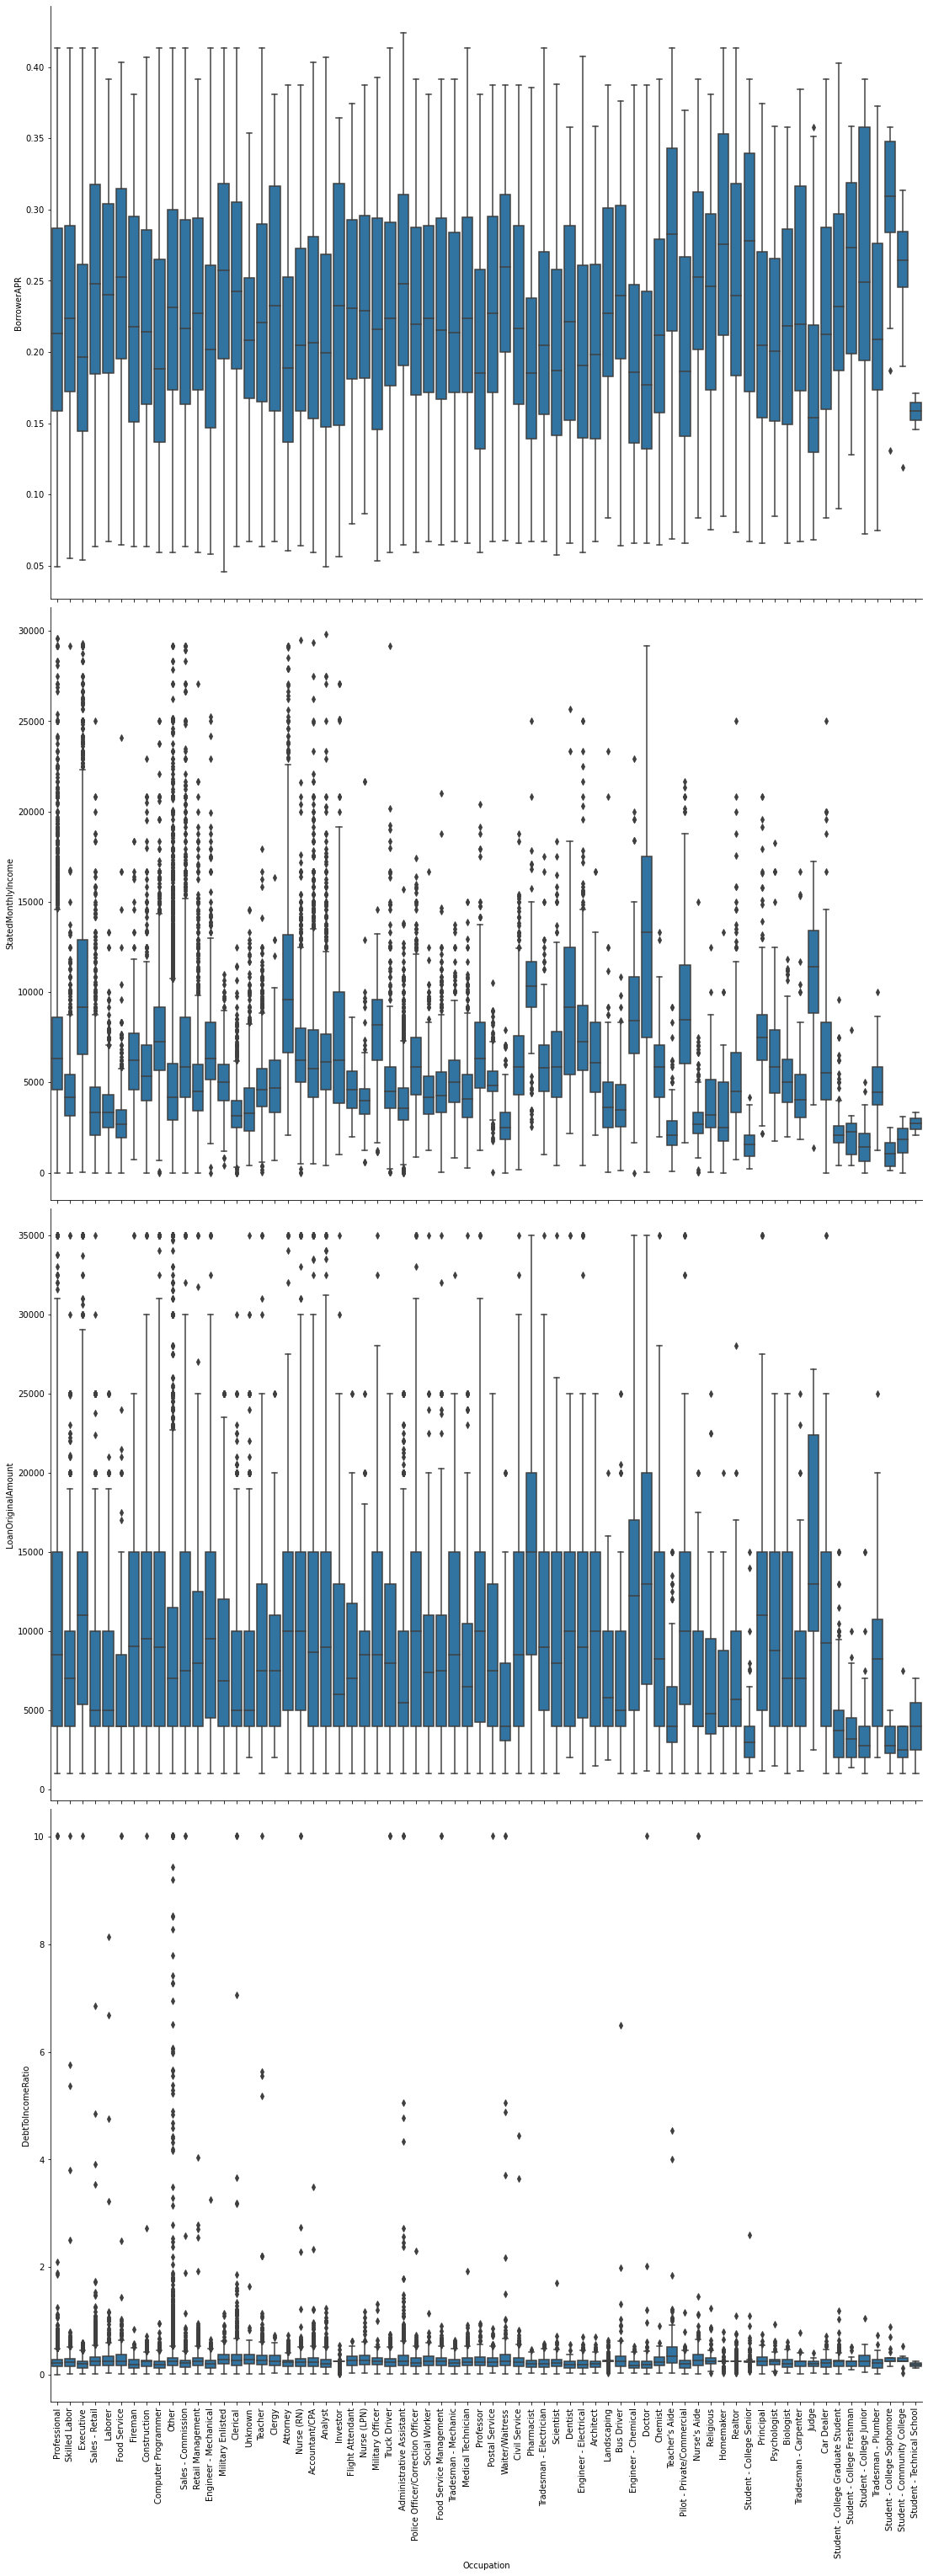

In [58]:
def boxgrid(x, y, **kwargs):
    """ Quick hack for creating box plots with seaborn's PairGrid. """
    default_color = sb.color_palette()[0]
    sb.boxplot(x, y, color = default_color)

plt.figure(figsize = [20, 20])
g = sb.PairGrid(data = df_loan, y_vars = ['BorrowerAPR', 'StatedMonthlyIncome', 'LoanOriginalAmount','DebtToIncomeRatio'], 
                x_vars = ['Occupation'] , height = 10, aspect = 1.5)
g.map(boxgrid);
plt.xticks(rotation=90);

<Figure size 720x720 with 0 Axes>

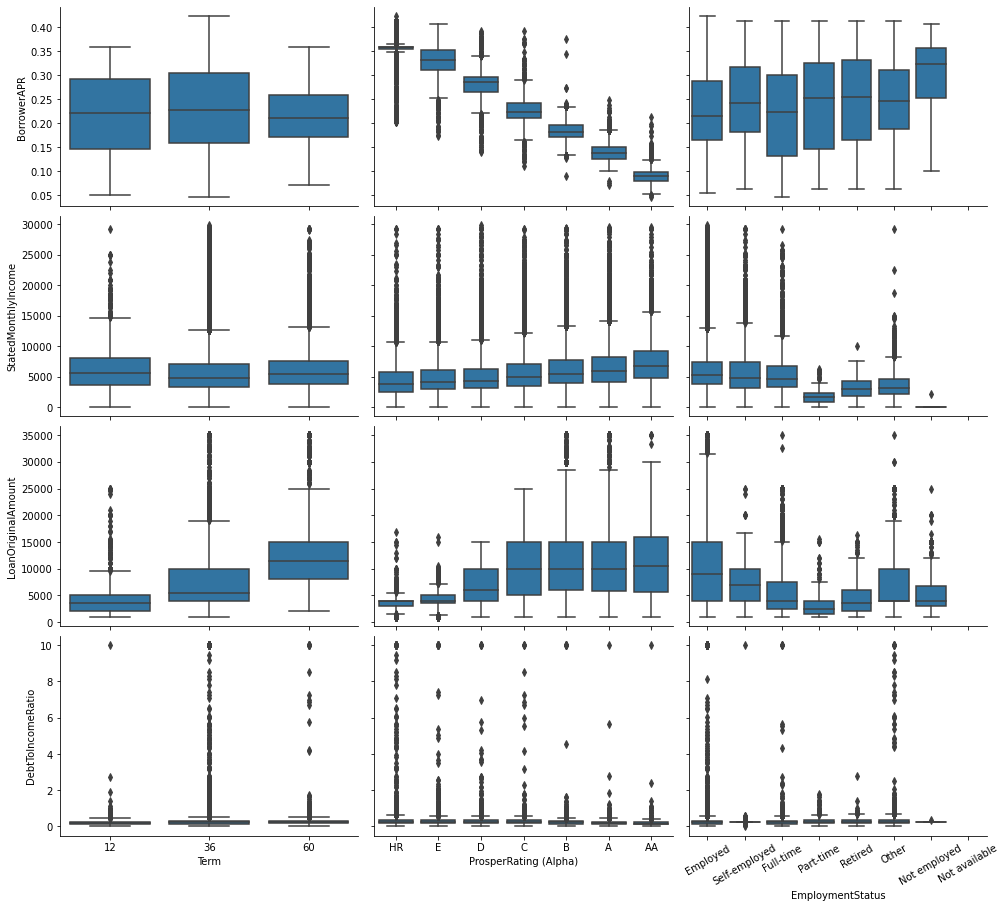

In [59]:

def boxgrid(x, y, **kwargs):
    """ Quick hack for creating box plots with seaborn's PairGrid. """
    default_color = sb.color_palette()[0]
    sb.boxplot(x, y, color = default_color)

plt.figure(figsize = [10, 10])
g = sb.PairGrid(data = df_loan, y_vars = ['BorrowerAPR', 'StatedMonthlyIncome', 'LoanOriginalAmount','DebtToIncomeRatio'], 
                x_vars = ['Term','ProsperRating (Alpha)', 'EmploymentStatus'], height = 3, aspect = 1.5)
g.map(boxgrid);
plt.xticks(rotation=30);

loan amount is increased with the increase of loan term. The borrower APR decreases with the better rating. Borrowers with the best Prosper ratings have the lowest APR. It means that the Prosper rating has a strong effect on borrower APR. Borrowers with better rating also have larger monthly income and loan amount. Employed, self-employed and full time borrowers have more monthly income and loan amount than part-time, retired and not employed borrowers.

Then lets see relations between categorical values.

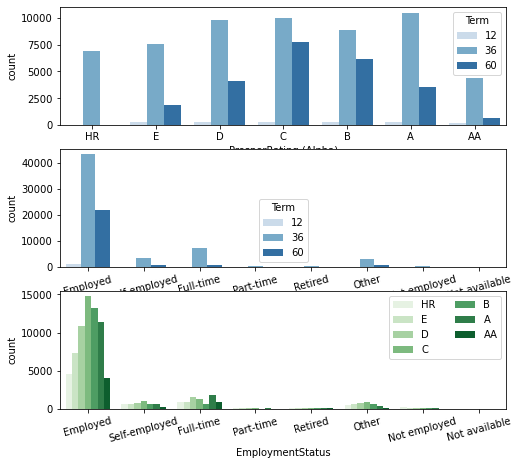

In [60]:
plt.figure(figsize = [8, 10])

# subplot 1: Prosper rating vs term
plt.subplot(4, 1, 1)
sb.countplot(data = df_loan, x = 'ProsperRating (Alpha)', hue = 'Term', palette = 'Blues')

# subplot 2: employment status vs. term
ax = plt.subplot(4, 1, 2)
sb.countplot(data = df_loan, x = 'EmploymentStatus', hue = 'Term', palette = 'Blues')
plt.xticks(rotation = 15)


# subplot 3: Prosper rating vs. employment status, use different color palette
ax = plt.subplot(4, 1, 3)
sb.countplot(data = df_loan, x = 'EmploymentStatus', hue = 'ProsperRating (Alpha)', palette = 'Greens')
ax.legend(loc = 1, ncol = 2); # re-arrange legend to remove overlapping
plt.xticks(rotation = 15);

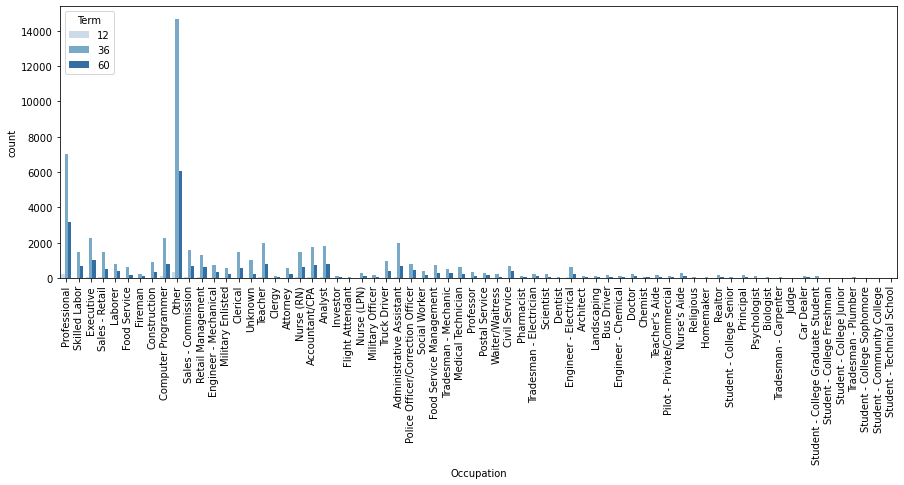

In [61]:
plt.figure(figsize = [15,5])
sb.countplot(data = df_loan, x = 'Occupation', hue = 'Term', palette = 'Blues');
plt.xticks(rotation=90);

Employment status variable do not have enough data on part-time, retired and not employed borrowers to show its interaction with term and Prosper rating variables. But we can see that there is a interaction between term and Prosper rating. Proportionally, there are more 60 month loans on B and C ratings. There is only 36 months loans for HR rating borrowers.

Are borrower APR and loan original amount  related to one another for all of the data?

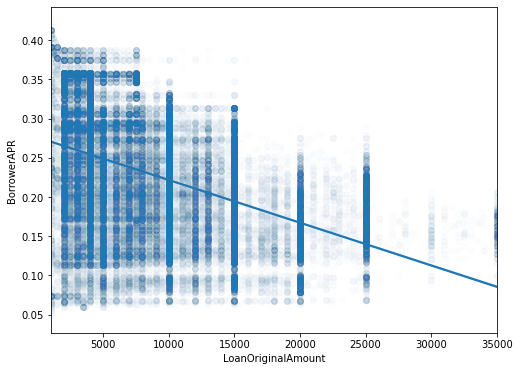

In [62]:
plt.figure(figsize = [8, 6])
sb.regplot(data = df_loan, x = 'LoanOriginalAmount', y = 'BorrowerAPR', scatter_kws={'alpha':0.01});

Different size of the loan amount, the APR has a large range, but the range of APR decrease with the increase of loan amount. Overall, the borrower APR is negatively correlated with loan amount.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?
Borrower APR is negatively associated with the loan original amount, which mean the more the loan amount, the lower the APR. It also shows that at different size of the loan amount, the APR has a large range, but the range of APR decrease with the increase of loan amount. The Prosper rating also has a strong effect on the borrower APR, which decreases with the better rating.
### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?
The loan original amount is positively correlated with the stated monthly income, it makes sense since borrowers with more monthly income could loan more money. It also shows that borrowers with better rating also have larger monthly income and loan amount. There is a interaction between prosper rating and term. Proportionally, there are more 60 month loans on B and C ratings. There is only 36 months loans for HR rating borrowers.

## Multivariate Exploration

How the categorical variable (Prosper rating and term) play into the relationship between borrower APR and loan original amount.

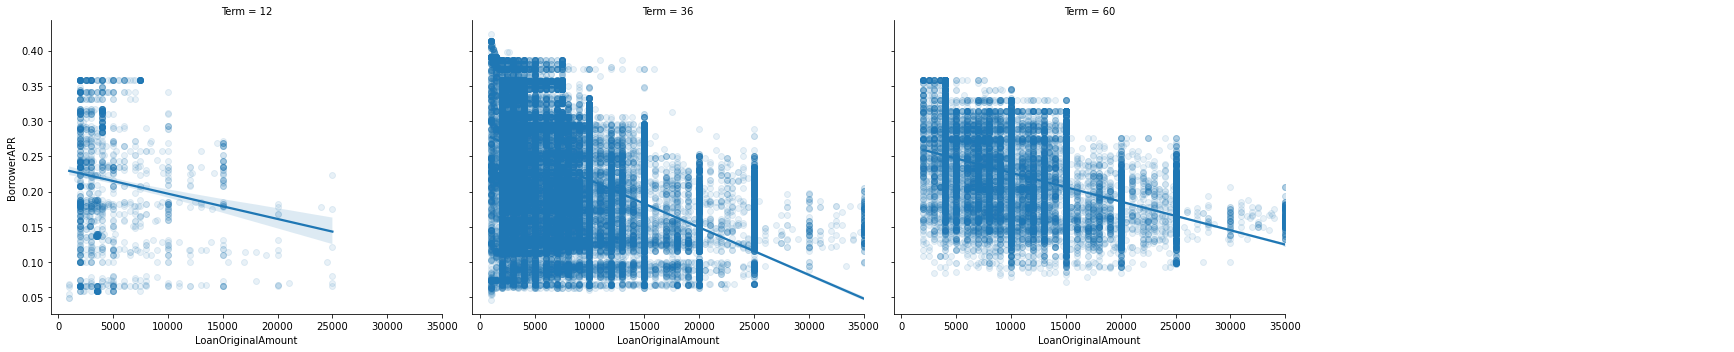

In [63]:
g=sb.FacetGrid(data= df_loan, aspect=1.2, height=5, col='Term', col_wrap=4)
g.map(sb.regplot, 'LoanOriginalAmount', 'BorrowerAPR', x_jitter=0.04, scatter_kws={'alpha':0.1});
g.add_legend();

term doesnt have effect on  apr and loan amount.

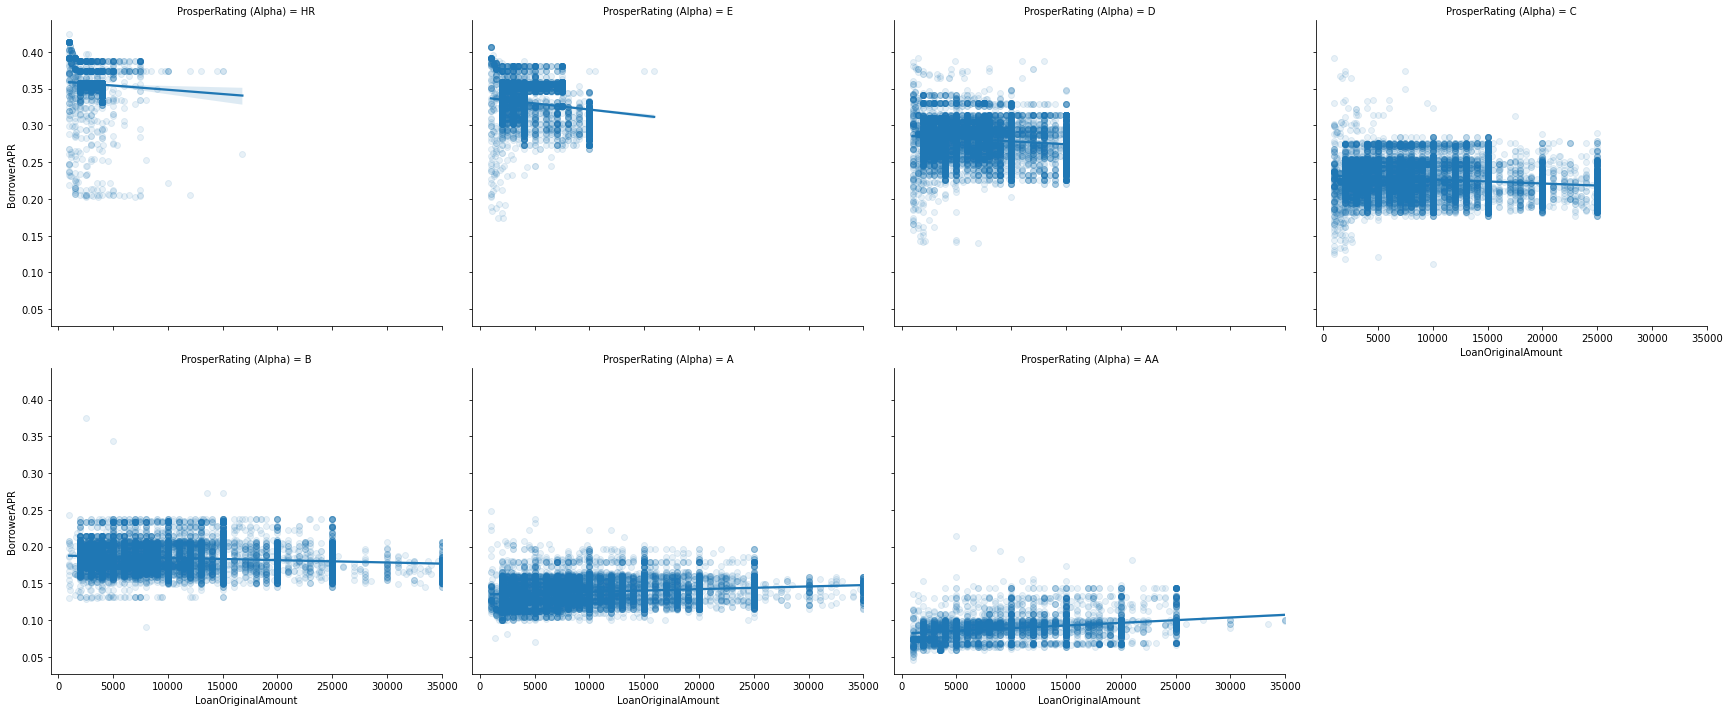

In [64]:
g=sb.FacetGrid(data=df_loan, aspect=1.2, height=5, col='ProsperRating (Alpha)', col_wrap=4)
g.map(sb.regplot, 'LoanOriginalAmount', 'BorrowerAPR', x_jitter=0.04, scatter_kws={'alpha':0.1});
g.add_legend();

Loan amount increases with better rating. The borrower APR decreases with better rating. Interestingly, the relationship between borrower APR and loan amount turns from negative to slightly positive when the Prosper ratings are increased from HR to A or better. This may because people with A or AA ratings tend to borrow more money, increasting APR could prevent them borrow even more and maximize the profit. But people with lower ratings tend to borrow less money, decreasing APR could encourage them to borrow more.

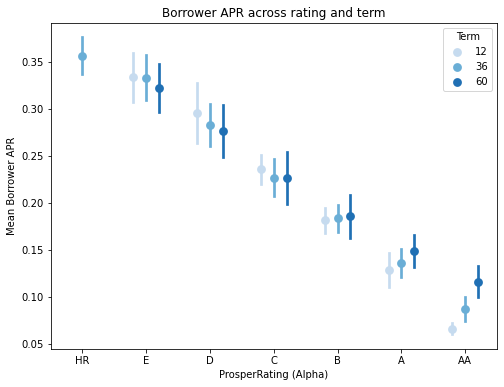

In [65]:
fig = plt.figure(figsize = [8,6])
ax = sb.pointplot(data = df_loan, x = 'ProsperRating (Alpha)', y = 'BorrowerAPR', hue = 'Term',
           palette = 'Blues', linestyles = '', dodge = 0.4, ci='sd')
plt.title('Borrower APR across rating and term')
plt.ylabel('Mean Borrower APR')
ax.set_yticklabels([],minor = True);

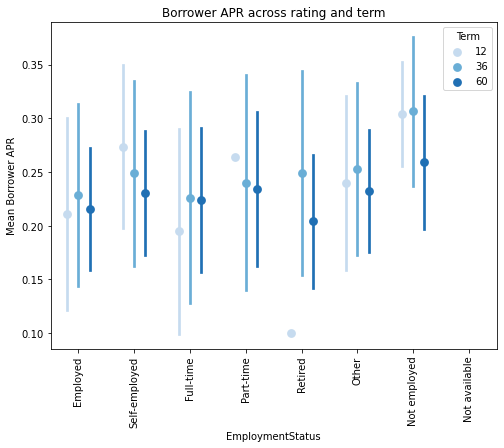

In [66]:
fig = plt.figure(figsize = [8,6])
ax = sb.pointplot(data = df_loan, x = 'EmploymentStatus', y = 'BorrowerAPR', hue = 'Term',
           palette = 'Blues', linestyles = '', dodge = 0.4, ci='sd')
plt.title('Borrower APR across rating and term')
plt.ylabel('Mean Borrower APR')
ax.set_yticklabels([],minor = True);
plt.xticks(rotation = 90);

the borrower APR decrease with the increase of borrow term for people with HR-C raings. But for people with B-AA ratings, the APR increase with the increase of borrow term.



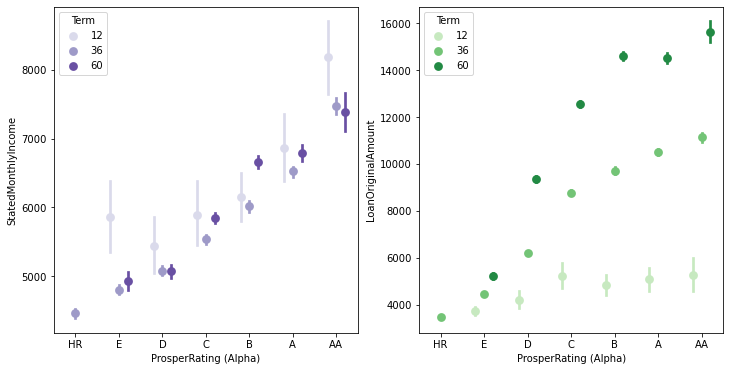

In [67]:
fig, ax = plt.subplots(ncols=2, figsize=[12,6])
sb.pointplot(data = df_loan, x = 'ProsperRating (Alpha)', y = 'StatedMonthlyIncome', hue = 'Term',
           palette = 'Purples', linestyles = '', dodge = 0.4, ax=ax[0])
sb.pointplot(data = df_loan, x = 'ProsperRating (Alpha)', y = 'LoanOriginalAmount', hue = 'Term',
           palette = 'Greens', linestyles = '', dodge = 0.4, ax=ax[1]);

It  doesn't seem like there is a interaction effect between term and rating, the pattern of term is similar among different ratings. But for loan amount, there is a interaction between term and rating. We can see that with better Prosper rating, the loan amount of all three terms increases, the increase amplitude of loan amount between terms also becomes larger.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

I extended my investigation of borrower APR against loan amount by looking at the impact of the Prosper rating. The multivariate exploration showed that the relationship between borrower APR and loan amount turns from negative to slightly positive when the Prosper ratings increased from HR to AA. I then explored the rating and term effects on loan amount, it shows that with better Prosper rating, the loan amount of all three terms increases, the increase amplitude of loan amount between terms also becomes larger.      

### Were there any interesting or surprising interactions between features?

A surprising interaction is that the borrower APR and loan amount is negatively correlated when the Prosper ratings are from HR to B, but the correlation is turned to be positive when the ratings are A and AA. Another interesting thing is that the borrower APR decrease with the increase of borrow term for people with HR-C raings. But for people with B-AA ratings, the APR increase with the borrow term.